In [18]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Query examples

Overview of all 2-lickport foraging sessions<br>
`session_task_protocol = 100` two-lickport foraging task<br>
`session_real_foraging` excludes very early training sessions where reward probabilities are [0, 1]

In [5]:
h2o = lab.WaterRestriction.proj('water_restriction_number')   # Water restriction number
foraging_sessions = (foraging_analysis.SessionTaskProtocol() * h2o                      
                     & 'session_task_protocol = 100' & 'session_real_foraging')
foraging_sessions

subject_id institution 6 digit animal ID,session session number,session_task_protocol the number of the dominant task protocol in the session,"session_real_foraging True if it is real foraging, false in case of pretraining",water_restriction_number WR number
447921,3,100,1,HC16
447921,4,100,1,HC16
447921,5,100,1,HC16
447921,6,100,1,HC16
447921,7,100,1,HC16
447921,8,100,1,HC16
447921,9,100,1,HC16
447921,10,100,1,HC16
447921,11,100,1,HC16
447921,12,100,1,HC16


How many sessions for each mouse

In [6]:
(h2o.aggr(foraging_sessions.proj(), num_sessions='count(*)') * h2o).fetch(format='frame', order_by='water_restriction_number')

,num_sessions,water_restriction_number
subject_id,,
453478,22,FOR01
453475,23,FOR02
453477,25,FOR03
453476,24,FOR04
455525,56,FOR05
455526,56,FOR06
457494,41,FOR07
457495,40,FOR08
457496,39,FOR09


Plot summary of an example session

In [4]:
sess_key={'subject_id': 482350, 'session': 52}

In [ ]:
from pipeline.plot.foraging_plot import plot_foragingWebGUI_session
plot_foragingWebGUI_session(wr_name_selected=(h2o & sess_key).fetch1('water_restriction_number'), session_selected=sess_key['session'])

# Model fitting results

## All models

In [7]:
foraging_model.Model()

model_id,"model_class e.g. LossCounting, RW1972, Hattori2019",model_notation,n_params Effective param count,is_bias,is_epsilon_greedy,is_softmax,is_choice_kernel,desc Long name,fit_cmd Fitting command compatible with the Dynamic-Foraing repo
0,LossCounting,"LossCounting ($\mu_{LC}$, $\sigma_{LC}$)",2,0,0,0,0,"LossCounting: mean, std, no bias",=BLOB=
1,RW1972,"RW1972_epsi ($\alpha$, $\epsilon$)",2,0,1,0,0,"SuttonBarto: epsilon, no bias",=BLOB=
2,RW1972,"RW1972_softmax ($\alpha$, $\sigma$)",2,0,0,1,0,"SuttonBarto: softmax, no bias",=BLOB=
3,LNP,"LNP_softmax ($\tau_1$, $\sigma$)",2,0,0,1,0,"Sugrue2004, Corrado2005: one tau, no bias",=BLOB=
4,LNP,"LNP_softmax ($\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$)",4,0,0,1,0,"Corrado2005, Iigaya2019: two taus, no bias",=BLOB=
5,Bari2019,"Bari2019 ($\alpha$, $\delta$, $\sigma$)",3,0,0,1,0,"RL: chosen, unchosen, softmax, no bias",=BLOB=
6,Hattori2019,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\sigma$)",3,0,0,1,0,"RL: rew, unrew, softmax, no bias",=BLOB=
7,Hattori2019,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$)",4,0,0,1,0,"RL: rew, unrew, unchosen, softmax, no bias",=BLOB=
8,RW1972,"RW1972_epsi ($\alpha$, $\epsilon$, $b_L$)",3,1,1,0,0,SuttonBarto: epsilon,=BLOB=
9,RW1972,"RW1972_softmax ($\alpha$, $\sigma$, $b_L$)",3,1,0,1,0,SuttonBarto: softmax,=BLOB=


Show param settings of a specified model

In [8]:
foraging_model.Model.Param & 'model_id=25'

model_id,"model_param e.g. learn_rate, epsilon, w_tau1","param_idx To keep params the same order as the original definition in MODELS, hence `fit_result.x`",param_lower_bound,param_higher_bound
25,biasL,5,-5.0,5.0
25,forget_rate,1,0.0,1.0
25,I0,2,0.0,1000000.0
25,learn_rate,0,0.0,1.0
25,rho,3,-1000000.0,1000000.0
25,softmax_temperature,4,0.01,15.0


## All model comparison groups

In [7]:
foraging_model.ModelComparison()

model_comparison_idx,desc
0,all_models
1,models_with_bias
2,models_with_bias_and_choice_kernel


## Example session

`model_comparison_idx` = 1: all models with bias term<br>
`sort='aic'`: sorted by AIC, from best to worst

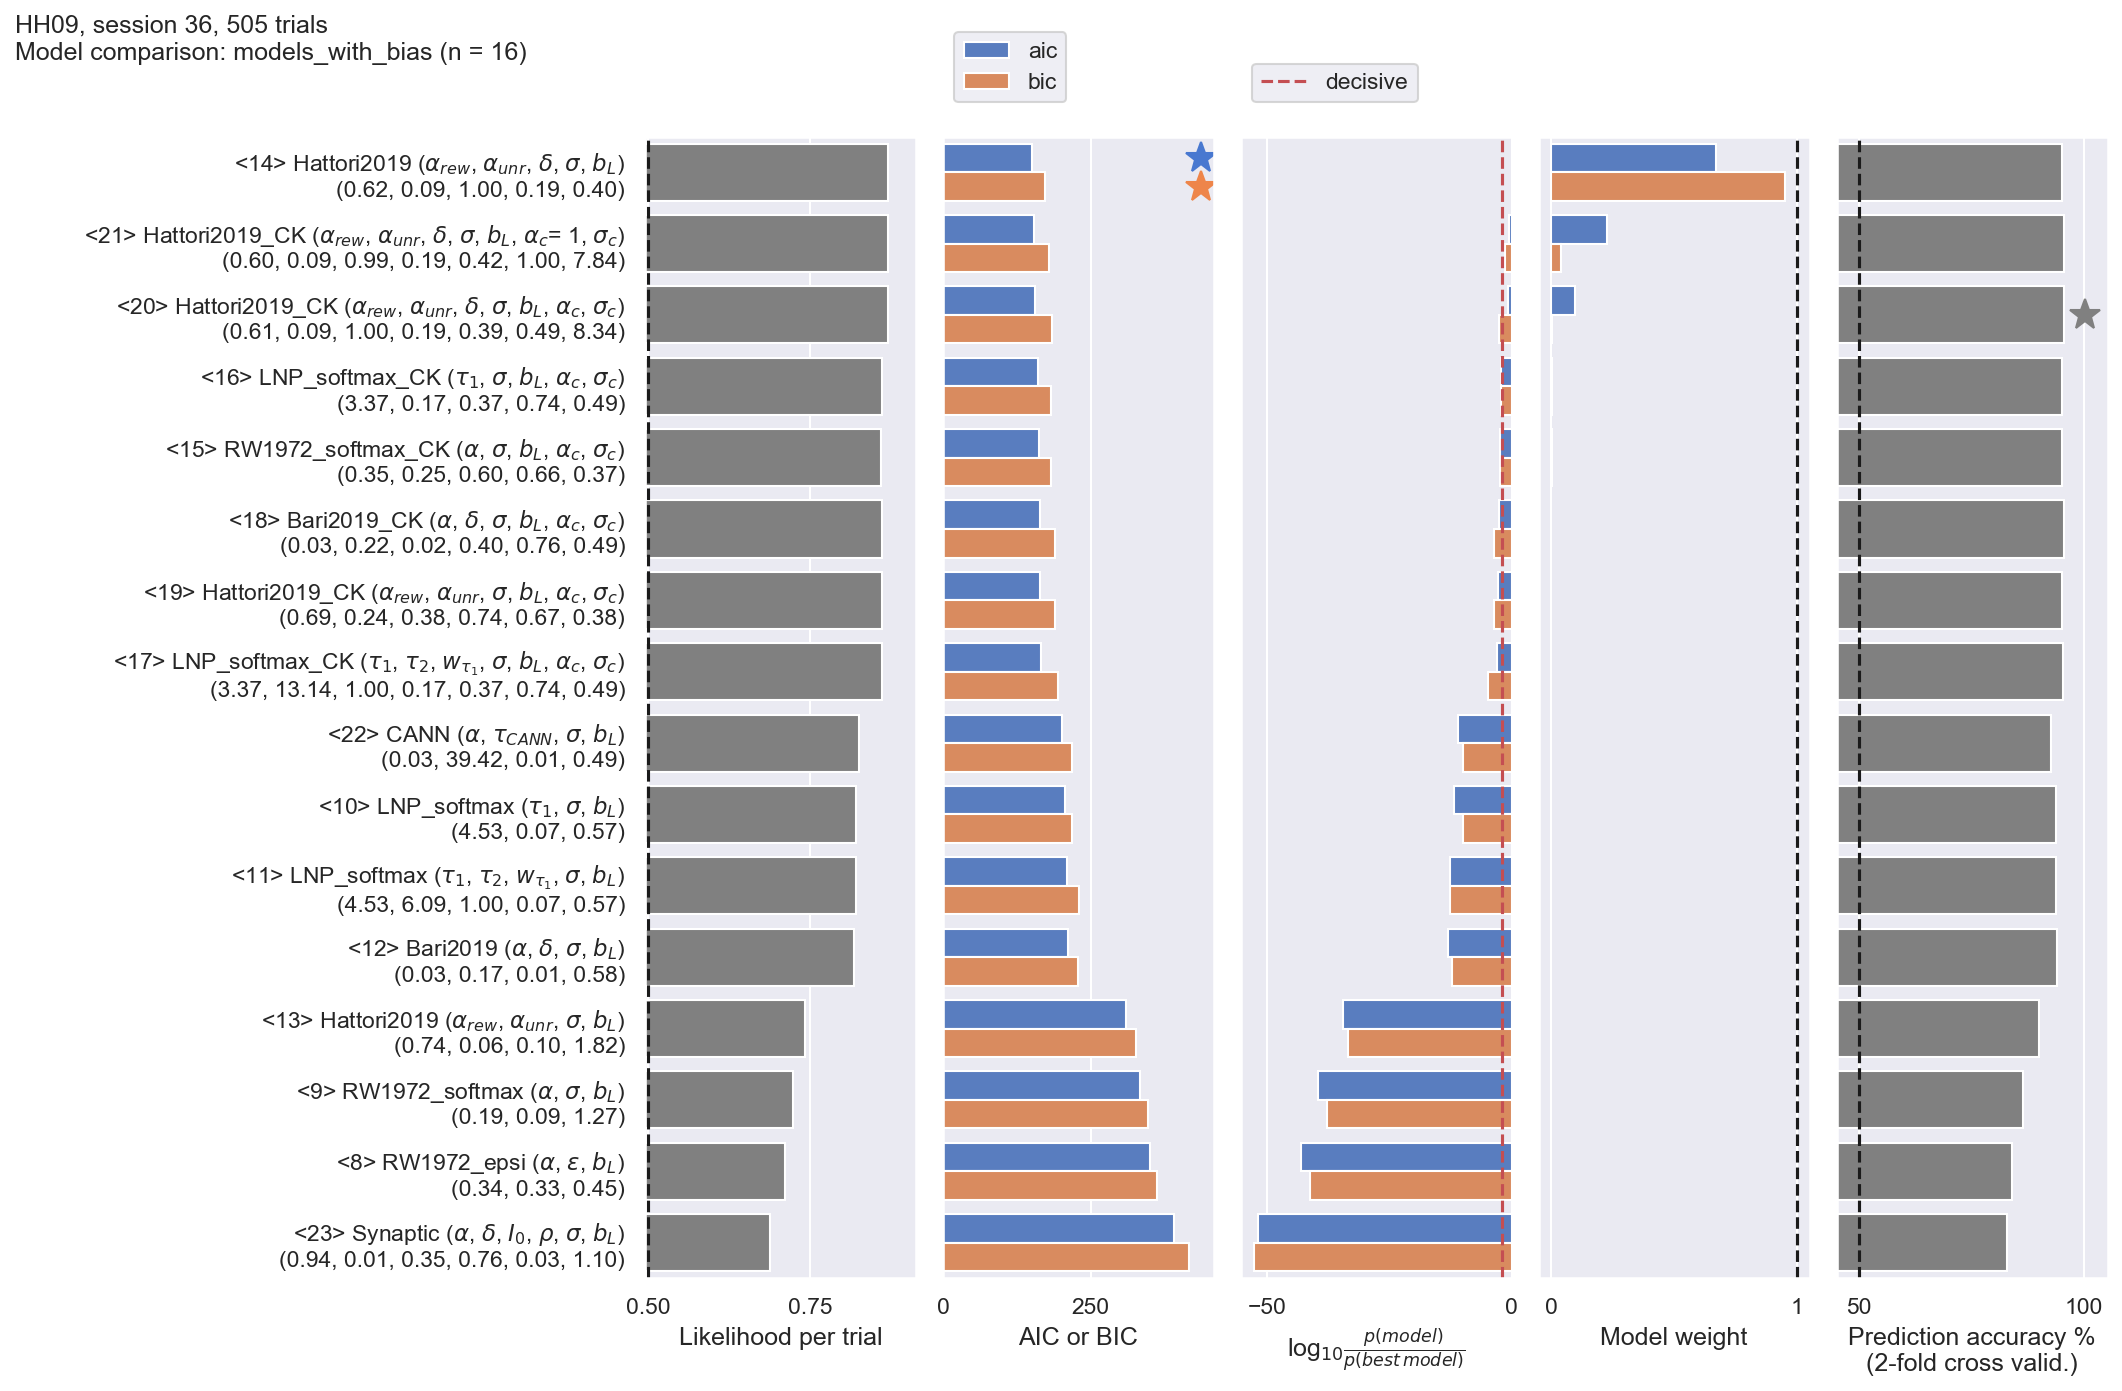

In [8]:
sess_key = {'subject_id': 473361, 'session': 36}
plot_session_model_comparison(sess_key, model_comparison_idx=1, sort='aic')

Raw fitted results

In [9]:
foraging_model.Model.proj('model_notation') * (foraging_model.FittedSessionModel & sess_key) 

model_id,subject_id institution 6 digit animal ID,session session number,model_notation,n_trials,n_params,log_likelihood raw log likelihood of the model,aic AIC,bic BIC,lpt Likelihood-Per-Trial raw,lpt_aic Likelihood-Per-Trial with AIC penalty,lpt_bic Likelihood-Per-Trial with AIC penalty,prediction_accuracy non-cross-validated prediction accuracy,cross_valid_accuracy_fit cross-validated accuracy (fitting set),cross_valid_accuracy_test cross-validated accuracy (testing set),cross_valid_accuracy_test_bias_only accuracy predicted only by bias (testing set)
0,473361,36,"LossCounting ($\mu_{LC}$, $\sigma_{LC}$)",505,2,-182.991,369.982,378.431,0.696033,0.693282,0.687506,0.918812,0.918847,0.916847,nan
1,473361,36,"RW1972_epsi ($\alpha$, $\epsilon$)",505,2,-215.631,435.262,443.711,0.652469,0.64989,0.644476,0.847525,0.845536,0.843552,nan
2,473361,36,"RW1972_softmax ($\alpha$, $\sigma$)",505,2,-199.303,402.607,411.056,0.673909,0.671245,0.665653,0.843564,0.83567,0.835694,nan
3,473361,36,"LNP_softmax ($\tau_1$, $\sigma$)",505,2,-104.699,213.398,221.847,0.812756,0.809543,0.802799,0.952475,0.952459,0.952459,nan
4,473361,36,"LNP_softmax ($\tau_1$, $\tau_2$, $w_{\tau_1}$, $\sigma$)",505,4,-104.67,217.339,234.237,0.812803,0.80639,0.793011,0.952475,0.948538,0.946538,nan
5,473361,36,"Bari2019 ($\alpha$, $\delta$, $\sigma$)",505,3,-106.876,219.752,232.425,0.80926,0.804467,0.794435,0.946535,0.948499,0.946538,nan
6,473361,36,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\sigma$)",505,3,-197.308,400.616,413.29,0.676577,0.67257,0.664183,0.847525,0.843544,0.843544,nan
7,473361,36,"Hattori2019 ($\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\sigma$)",505,4,-71.9209,151.842,168.74,0.867259,0.860417,0.846141,0.958416,0.95838,0.95838,nan
8,473361,36,"RW1972_epsi ($\alpha$, $\epsilon$, $b_L$)",505,3,-171.802,349.605,362.279,0.711626,0.707411,0.69859,0.845545,0.849442,0.839552,0.641571
9,473361,36,"RW1972_softmax ($\alpha$, $\sigma$, $b_L$)",505,3,-163.608,333.215,345.889,0.723268,0.718984,0.710019,0.865347,0.863393,0.863393,0.641579


Plot fitted choice traces of best and worst models

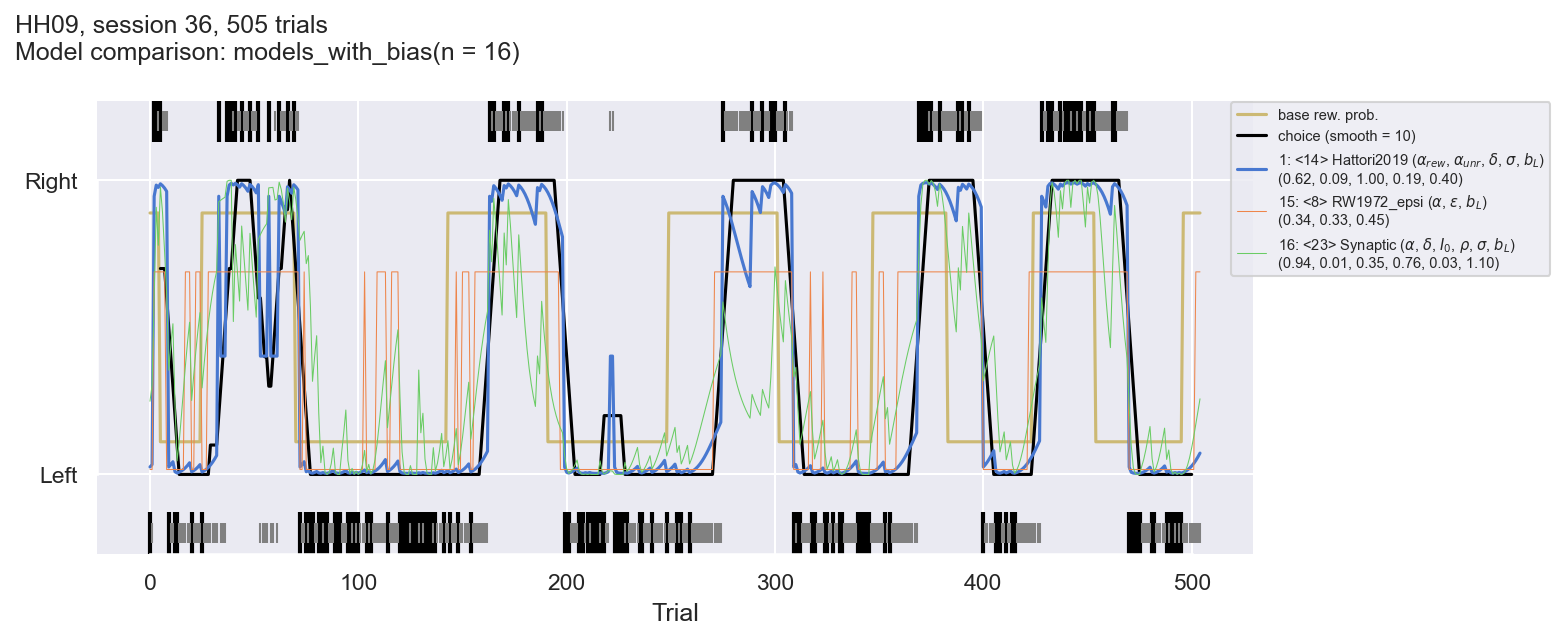

In [10]:
plot_session_fitted_choice(sess_key=sess_key, first_n=1, last_n=2, smooth_factor=10, model_comparison_idx=1)

Plot specified models

CANN model (22), Synaptic (23), and Hattori (14)

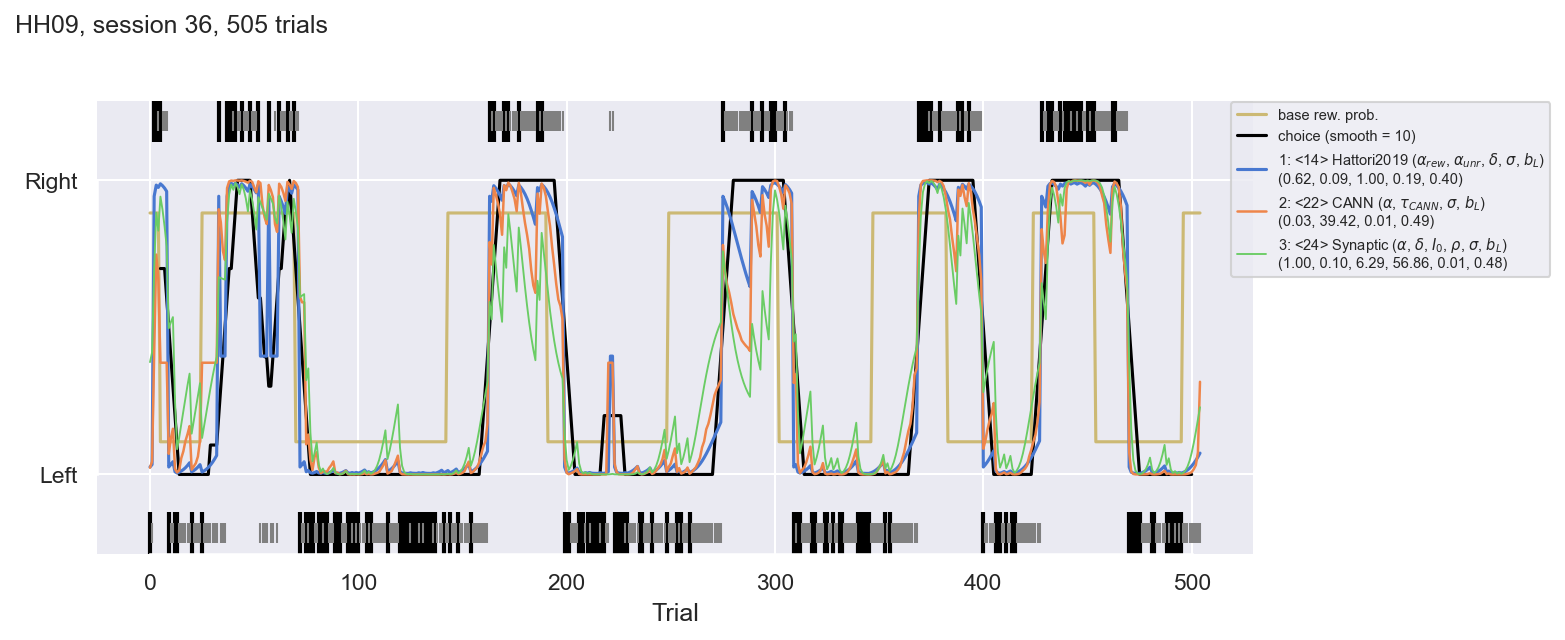

In [11]:
plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=[22, 24, 14], smooth_factor=10)

## Query of fitted params

All fitted params are stored in the part table `foraging_model.FittedSessionModel.Param`

In [10]:
foraging_model.FittedSessionModel.Param.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
model_id             : int                          # 
model_param          : varchar(32)                  # e.g. learn_rate, epsilon, w_tau1
---
fitted_value         : float                        # 

Models from Ulises

In [60]:
Ulises_model = (foraging_model.Model & 'model_class in ("CANN", "Synaptic")')
Ulises_model

model_id,"model_class e.g. LossCounting, RW1972, Hattori2019",model_notation,n_params Effective param count,is_bias,is_epsilon_greedy,is_softmax,is_choice_kernel,desc Long name,fit_cmd Fitting command compatible with the Dynamic-Foraing repo
22,CANN,"CANN ($\alpha$, $\tau_{CANN}$, $\sigma$, $b_L$)",4,1,0,1,0,"Ulises' CANN model, ITI decay, with bias",=BLOB=
23,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model,=BLOB=
24,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model (unconstrained \rho),=BLOB=
25,Synaptic,"Synaptic ($\alpha$, $\delta$, $I_0$, $\rho$, $\sigma$, $b_L$)",6,1,0,1,0,Ulises' synaptic model (really unconstrained I_0 and \rho),=BLOB=


Show fit command

In [69]:
Ulises_model.fetch('fit_cmd')

array([list(['CANN', ['learn_rate', 'tau_cann', 'softmax_temperature', 'biasL'], [0, 0, 0.01, -5], [1, 1000, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, 0, 0.01, -5], [1, 1, 10, 1, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, -100, 0.01, -5], [1, 1, 10, 100, 15, 5]]),
       list(['Synaptic', ['learn_rate', 'forget_rate', 'I0', 'rho', 'softmax_temperature', 'biasL'], [0, 0, 0, -1000000.0, 0.01, -5], [1, 1, 1000000.0, 1000000.0, 15, 5]])],
      dtype=object)

Note the different bounds of $I_0$ and $\rho$ of the three Synaptic models.<br>
- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$
- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$
- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

Say, we're interested in the fully unconstrained Synaptic model (`model_id = 25`)

In [70]:
model_id = 25

Query ALL fitted params for one session

In [71]:
# From foraging_model.Model, we know model_id 24 is the Synaptic model
foraging_model.FittedSessionModel.Param & {'subject_id': 482350, 'session': 52, 'model_id': model_id}

subject_id institution 6 digit animal ID,session session number,model_id,"model_param e.g. learn_rate, epsilon, w_tau1",fitted_value
482350,52,25,biasL,-0.509805
482350,52,25,forget_rate,0.206364
482350,52,25,I0,109474.0
482350,52,25,learn_rate,0.625583
482350,52,25,rho,829900.0
482350,52,25,softmax_temperature,0.01


Quecy one fitted parmas, say, the `forget_rate`, for All sessions 

In [72]:
foraging_model.FittedSessionModel.Param & {'model_param': 'forget_rate', 'model_id': model_id}

subject_id institution 6 digit animal ID,session session number,model_id,"model_param e.g. learn_rate, epsilon, w_tau1",fitted_value
447921,3,25,forget_rate,1.0
447921,4,25,forget_rate,0.316802
447921,5,25,forget_rate,0.286211
447921,6,25,forget_rate,0.197288
447921,7,25,forget_rate,0.0836583
447921,8,25,forget_rate,0.215991
447921,9,25,forget_rate,0.00890963
447921,10,25,forget_rate,0.306401
447921,11,25,forget_rate,0.166334
447921,12,25,forget_rate,0.149981


Plot distributions of fitted params (`learn_rate` and `tau` of the RNN model)

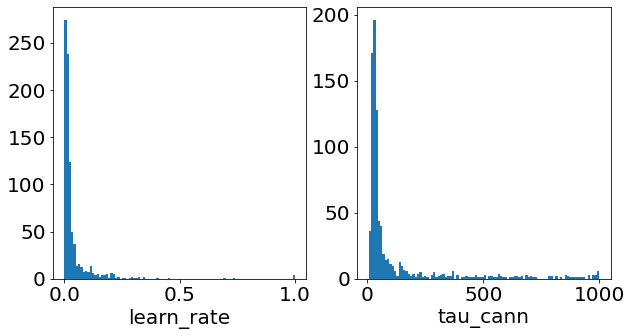

In [19]:
model_id = 22
params = ['learn_rate', 'tau_cann']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

## Problems in Synaptic model?

For `model_id = 23`,  Some fitted $\rho$s are at the boundary 0 and 1

- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$

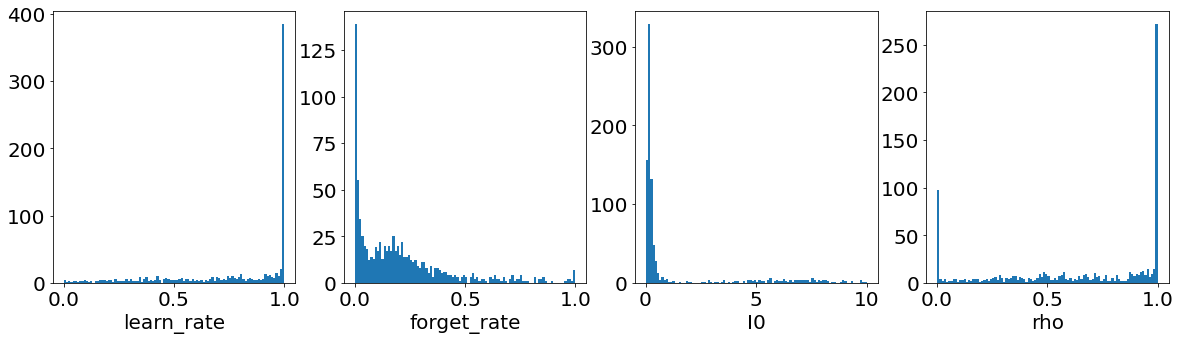

In [20]:
model_id = 23
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$

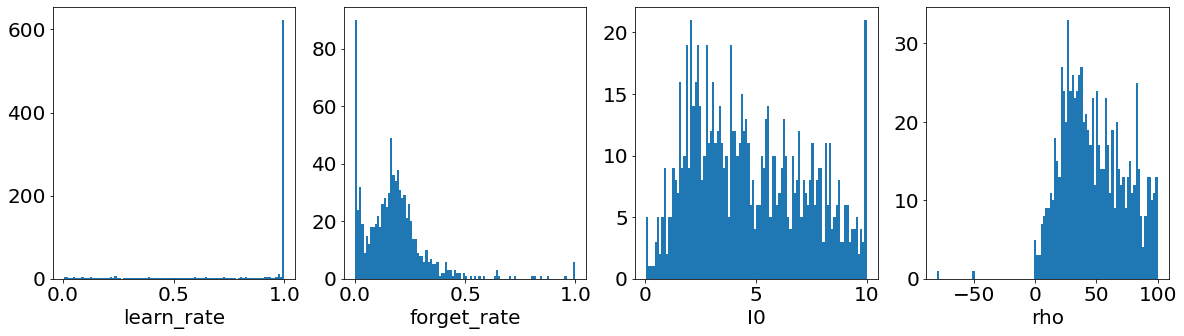

In [21]:
model_id = 24
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

$\rho$ is clearly problematic if unconstrained...

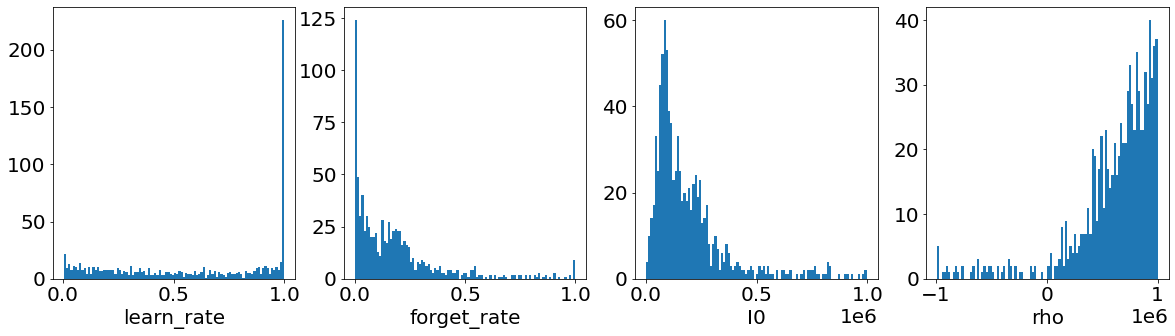

In [22]:
model_id = 25
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

In the following example, `model_id=23` failed, but `24` and `25` look fine, although there's a clear overfitting in `25` (huge $I_0$ and $\rho$)

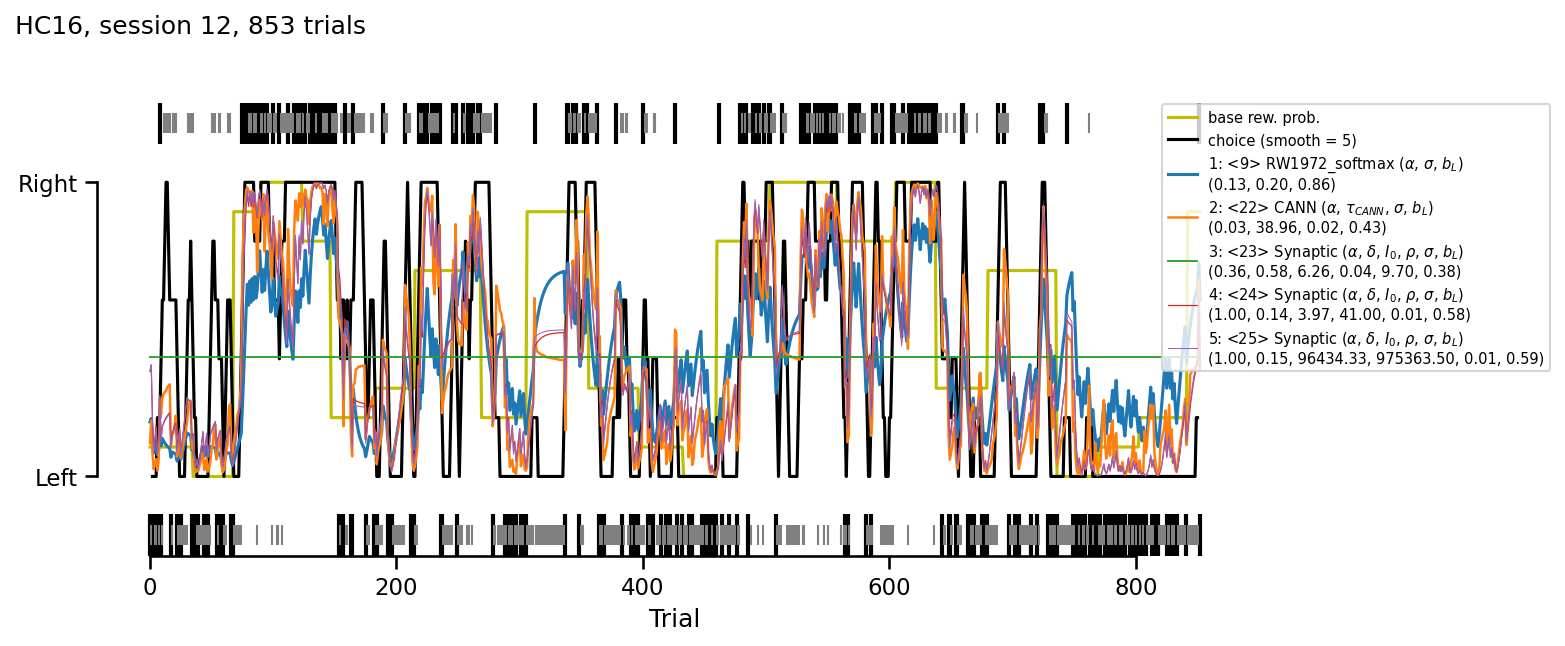

In [101]:
key = (experiment.Session & (foraging_model.FittedSessionModel & 'model_id = 23')).fetch('KEY', limit=1, offset=9)[0]
plot_session_fitted_choice(key, specified_model_ids=[9, 22, 23, 24, 25])

## Compare models by AIC

Here I'm comparing overal fitting qualities of five models

`lpt_aic` is the likelihood per trial with AIC penality (the larger, the better)

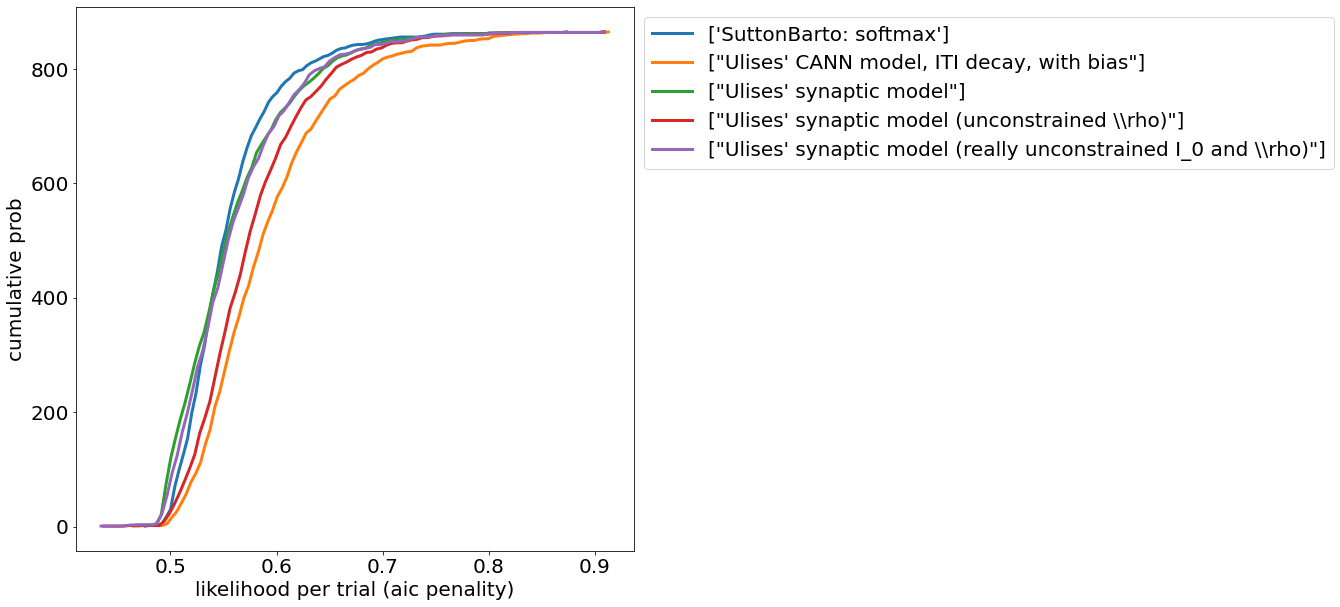

In [25]:
model_ids = [9, 22, 23, 24, 25]
_, ax = plt.subplots(1, 1, figsize=(10, 10))

for model_id in model_ids:
    lpt_aic = (foraging_model.FittedSessionModel & {'model_id': model_id}).fetch('lpt_aic')
    cnt, bin = np.histogram(lpt_aic, bins=100)
    plt.plot(bin[:-1], np.cumsum(cnt), lw=3, label=(foraging_model.Model & {'model_id': model_id}).fetch('desc'))

ax.set(xlabel='likelihood per trial (aic penality)', ylabel='cumulative prob')
_ = ax.legend(bbox_to_anchor=[1, 1])    

Conclusion:
1. `CANN` is better than `SuttonBarto` (which is the same as `CANN` except the ITI-dependent decay)
2. Mildly constrained Synaptic model `24` (red) is better than tightly constrained `23` (green) or unconstrained `25` (purple) models.